### Fundamentals of Natural Language Processing
# Negation and Uncertainty Detection using a Machine-Learning Based Approach

*Authors:*

> *Anna Blanco, Agustina Lazzati, Stanislav Bultaskii, Queralt Salvadó*

*Aims:*
> Our goal is to train various Machine Learning based models for each of the two sub-tasks (detection of negation and uncertainty signals, and detection of the negation and uncertainty scopes). In order to do so, we followed the implementation method described by *Enger, Velldal, and Øvrelid (2017)*, which employs a maximum-margin approach for negation detection. However, for our particular application, we also included uncertainty cues and scope detection.

*References:* 
<br>
> Enger, M., Velldal, E., & Øvrelid, L. (2017). *An open-source tool for negation detection: A maximum-margin approach*. Proceedings of the Workshop on Computational Semantics Beyond Events and Roles (SemBEaR), 64–69.

---

We can erase this if you want but the thing is that we need to use the environment that queralt did. You need to write some commands to have the nlp_project (Python) as we have specific libraries. 

I did that and in the preprocessing it worked but here in order to work I had to run this command above, if it is not needed just avoid them!

In [14]:
import spacy

# Check installed models
print(spacy.util.get_installed_models())


['es_core_news_sm']


In [15]:
#!python -m spacy download es_core_news_sm


In [16]:
# Import necessary libraries and functions
import json
import spacy
from collections import defaultdict
import re
import pandas as pd
from preprocessing import df_svm_neg_test, df_svm_neg_train, df_svm_neg_test, df_svm_unc_train, df_svm_unc_test, df_crf_neg_train, df_crf_neg_test, df_crf_unc_train, df_crf_unc_test

## CUE DETECTION USING SVM

First of all, we'll need to vectorize:

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from joblib import dump

def prepare_dataframe_for_svm(df, label_col):
    drop_cols = ["sentence_id", "token_id", label_col]
    feature_dicts = df.drop(columns=drop_cols).to_dict(orient="records")
    labels = df[label_col].tolist()

    vectorizer = DictVectorizer(sparse=True)
    X = vectorizer.fit_transform(feature_dicts)
    y = labels

    return X, y, vectorizer

def train_and_evaluate_svm(df_train, df_test, label_col, model_name):
    X_train, y_train, vec = prepare_dataframe_for_svm(df_train, label_col)
    X_test = vec.transform(df_test.drop(columns=["sentence_id", "token_id", label_col]).to_dict(orient="records"))
    y_test = df_test[label_col].tolist()

    pipeline = Pipeline([
        ("svm", LinearSVC(class_weight="balanced", max_iter=5000))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f"\n--- Evaluation for {model_name} ---")
    print(classification_report(y_test, y_pred, digits=3))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
    cm_df = pd.DataFrame(cm, index=pipeline.classes_, columns=pipeline.classes_)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

    # Save both the model and the vectorizer
    dump(pipeline, f"{model_name}.joblib")
    dump(vec, f"{model_name}_vectorizer.joblib")

    return pipeline


Matplotlib is building the font cache; this may take a moment.


### SVM for negation cue detection


--- Evaluation for svm_negation_cue ---
              precision    recall  f1-score   support

           0      1.000     0.998     0.999     64399
           1      0.916     0.996     0.954      1132

    accuracy                          0.998     65531
   macro avg      0.958     0.997     0.977     65531
weighted avg      0.998     0.998     0.998     65531



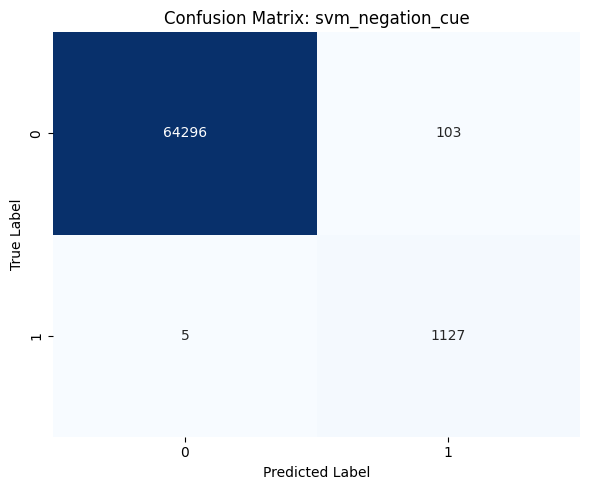

In [18]:
neg_cue_model = train_and_evaluate_svm(
    df_train=df_svm_neg_train,
    df_test=df_svm_neg_test,
    label_col="neg_cue_label",
    model_name="svm_negation_cue"
)

### SVM for uncertainty cue detection


--- Evaluation for svm_uncertainty_cue ---
              precision    recall  f1-score   support

           0      1.000     0.931     0.964    251284
           1      0.038     0.987     0.072       686

    accuracy                          0.931    251970
   macro avg      0.519     0.959     0.518    251970
weighted avg      0.997     0.931     0.962    251970



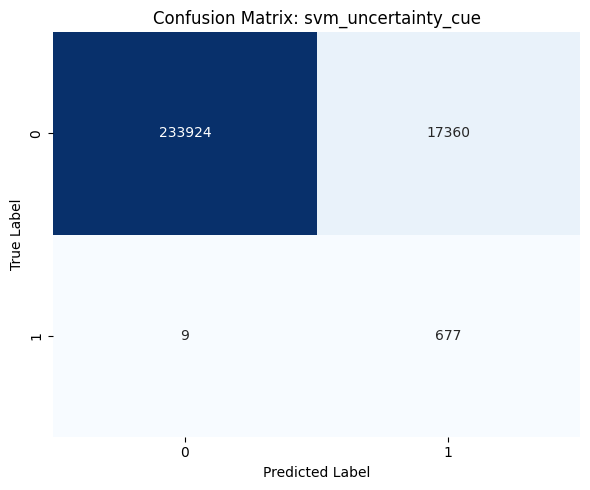

In [19]:
unc_cue_model = train_and_evaluate_svm(
    df_train=df_svm_unc_train,
    df_test=df_svm_unc_test,
    label_col="unc_cue_label",
    model_name="svm_uncertainty_cue"
)

In [20]:
def balance_training_data(df, label_col, neg_ratio=4, seed=42):
    positives = df[df[label_col] == 1]
    negatives = df[df[label_col] == 0].sample(n=len(positives) * neg_ratio, random_state=seed)
    df_balanced = pd.concat([positives, negatives]).sample(frac=1, random_state=seed).reset_index(drop=True)
    return df_balanced

df_balanced_unc_train = balance_training_data(df_svm_unc_train, label_col="unc_cue_label", neg_ratio=4)
print(df_balanced_unc_train["unc_cue_label"].value_counts())

unc_cue_label
0    2744
1     686
Name: count, dtype: int64



--- Evaluation for svm_uncertainty_cue_balanced ---
              precision    recall  f1-score   support

           0      1.000     0.929     0.963    251284
           1      0.036     0.987     0.070       686

    accuracy                          0.929    251970
   macro avg      0.518     0.958     0.517    251970
weighted avg      0.997     0.929     0.961    251970



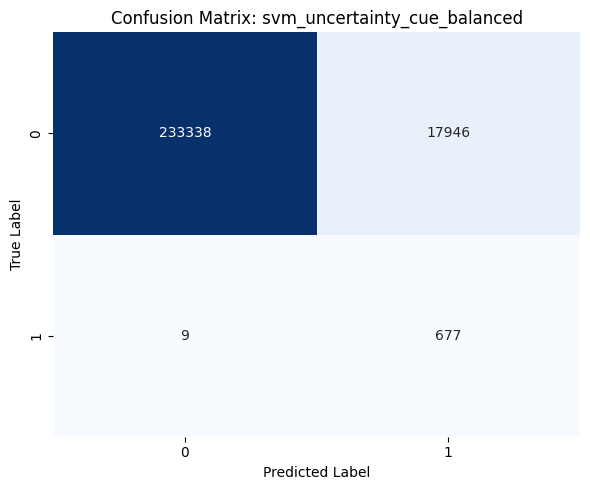

In [21]:
svm_unc_balanced_model = train_and_evaluate_svm(
    df_train=df_balanced_unc_train,
    df_test=df_svm_unc_test,
    label_col="unc_cue_label",
    model_name="svm_uncertainty_cue_balanced"
)

## SCOPE DETECTION USING CRF

In [22]:
# pip install sklearn-crfsuite

We'll use CRF BIO tagging:

**BIO tagging** is a way to label each word in a sentence to show if it is part of a scope (like negation or uncertainty). The labels are:

* **B** for the **Beginning** of the scope
* **I** for **Inside** the scope
* **O** for **Outside** the scope

We use BIO tagging to help machine learning models, like **CRFs (Conditional Random Fields)**, understand where a scope starts and ends. For example, if a sentence has a negation like “No tiene fiebre”, BIO tagging shows that “No” is the beginning (**B-SCOPE**) and “tiene fiebre” is inside the scope (**I-SCOPE**), while other words would be labeled **O** if they are not part of it.

Using BIO makes it easier for the model to learn patterns and detect complete scopes correctly, not just single words. 


In [23]:
df_svm_neg_train

,sentence_id,token_id,word,lemma,pos,prefix,suffix,is_punct,is_redacted,dep,head_pos,in_single_word_cues,in_affixal_cues,ends_with_ment,neg_cue_label
0,0,0,,,SPACE,,,0,0,dep,SPACE,0,0,0,0
1,1,0,nº,nº,NOUN,nº,nº,0,0,det,NOUN,0,0,0,0
2,1,1,historia,historia,NOUN,his,ria,0,0,ROOT,NOUN,0,0,0,0
3,1,2,clinica,clinico,ADJ,cli,ica,0,0,amod,NOUN,0,0,0,0
4,1,3,:,:,PUNCT,:,:,1,0,punct,NOUN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251965,12732,27,),),PUNCT,),),1,0,punct,NOUN,1,0,0,0
251966,12732,28,&,&,CCONJ,&,&,1,0,dep,NOUN,0,0,0,0
251967,12732,29,nbsp;ami-v-pee,nbsp;ami-v-pee,NUM,nbs,pee,0,0,det,NUM,0,0,0,0
251968,12732,30,2/2,2/2,NUM,2/2,2/2,0,0,obj,NOUN,0,0,0,0


In [24]:
#   IM GETTING ALL THE NEGATION AND THE UNC CUES FROM TRAIN DATAFRAME, 
#   maybe it should be done with the svm but i dont how. 
neg_cues = set()
unc_cues = set()
for _, row in df_svm_neg_train.iterrows():
    if row['neg_cue_label'] == 1:
        neg_cues.add(row['word'].lower())

for _, row in df_svm_unc_train.iterrows():
    if row['unc_cue_label'] == 1:
        unc_cues.add(row['word'].lower())


In [25]:
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics

def to_bio_labels(labels, label_type="SCOPE"):
    # Convert lists of binary labels (0/1) into BIO tagging format for scopes
    bio_labels = []
    prefix = label_type.upper() + '_SCOPE'  # e.g., NEG_SCOPE or UNC_SCOPE
    for sent in labels:
        bio = []
        prev = 0
        for i, tag in enumerate(sent):
            if tag == 1:
                if i == 0 or prev == 0:
                    bio.append(f'B-{prefix}')
                else:
                    bio.append(f'I-{prefix}')
            else:
                bio.append('O')
            prev = tag
        bio_labels.append(bio)
    return bio_labels

def df_to_crf_format(df, task, neg_cues=neg_cues, unc_cues=unc_cues):
    """
    Convert a DataFrame into a list of feature dictionaries per sentence for CRF input.
    Includes original features + contextual features + lexicon-based features.
    
    Parameters:
        df (pd.DataFrame): must contain columns like 'word', 'pos', 'prefix', 'suffix', etc.

    Returns:
        List of list of feature dicts (one per token, grouped by sentence)
    """
    sentences = []
    grouped = df.groupby("sentence_id")

    for _, group in grouped:
        sentence = []
        group = group.reset_index(drop=True)  # Reset index so we can use idx in loop

        for idx, row in group.iterrows():
            word_lower = row['word'].lower()

            features = {
                'word.lower()': word_lower,
                'word.isupper()': row['word'].isupper(),
                'word.istitle()': row['word'].istitle(),
                'pos': row['pos'],
                'pos_prefix': row['pos'][:2] if isinstance(row['pos'], str) else 'NA',
                'prefix': row['prefix'],
                'suffix': row['suffix'],
                'is_punct': row['is_punct'],
                'in_single_word_cues': row['in_single_word_cues'],
                'in_affixal_cues': row['in_affixal_cues'],
                'ends_with_ment': row['ends_with_ment'],
                'has_neg_prefix': word_lower.startswith(('un', 'in', 'non', 'dis')),
                'has_neg_suffix': word_lower.endswith(('less', "n't")),
                'is_modal': word_lower in unc_cues if task == "UNC" else word_lower in neg_cues
            }
    
            # dependency features
            if 'dep' in row and 'head_word' in row and 'head_pos' in row:
                features.update({
                    'dep_label': row['dep'],
                    'head_word': str(row['head_word']).lower(),
                    'head_pos': row['head_pos']
                })

            # Contextual features: previous and next token
            if idx > 0:
                prev_row = group.iloc[idx - 1]
                features.update({
                    '-1:word.lower()': prev_row['word'].lower(),
                    '-1:pos': prev_row['pos']
                })
            else:
                features['BOS'] = True  # Beginning of sentence

            if idx < len(group) - 1:
                next_row = group.iloc[idx + 1]
                features.update({
                    '+1:word.lower()': next_row['word'].lower(),
                    '+1:pos': next_row['pos']
                })
            else:
                features['EOS'] = True  # End of sentence

            sentence.append(features)
        sentences.append(sentence)

    return sentences


def df_to_labels(df, label_col):
    # Extracts label sequences from the DataFrame, grouped by sentence
    label_sequences = []
    grouped = df.groupby("sentence_id")
    for _, group in grouped:
        label_list = group[label_col].tolist()
        label_sequences.append(label_list)
    return label_sequences


In [26]:
# Train + evaluate CRF model
def train_and_evaluate_crf(df_train, df_test, label_col):
    # Trains and evaluates a CRF model for BIO tagging using specified label column (e.g., 'neg_scope_label')
    scope_type = "NEG" if "neg" in label_col.lower() else "UNC"

    X_train = df_to_crf_format(df_train, scope_type)
    y_train_raw = df_to_labels(df_train, label_col)
    y_train = to_bio_labels(y_train_raw, label_type=scope_type)

    X_test = df_to_crf_format(df_test, scope_type)
    y_test_raw = df_to_labels(df_test, label_col)
    y_test = to_bio_labels(y_test_raw, label_type=scope_type)

    crf = CRF(algorithm='lbfgs', max_iterations=100, all_possible_transitions=True)
    crf.fit(X_train, y_train)
    y_pred = crf.predict(X_test)

    print(f"CRF Evaluation for: {label_col.upper()}")
    print(metrics.flat_classification_report(y_test, y_pred))   
    
    return X_test, y_test, y_pred  # Return these variables for further use


### CRF for negation scope detection

In [27]:
# CRF BIO tagging evaluation for NEGATION scopes
X_test_NEG, y_test_NEG, y_pred_NEG = train_and_evaluate_crf(df_crf_neg_train, df_crf_neg_test, "neg_scope_label")

CRF Evaluation for: NEG_SCOPE_LABEL
              precision    recall  f1-score   support

 B-NEG_SCOPE       0.97      0.89      0.93      1071
 I-NEG_SCOPE       0.92      0.79      0.85      2522
           O       0.99      1.00      0.99     61938

    accuracy                           0.99     65531
   macro avg       0.96      0.89      0.92     65531
weighted avg       0.99      0.99      0.99     65531



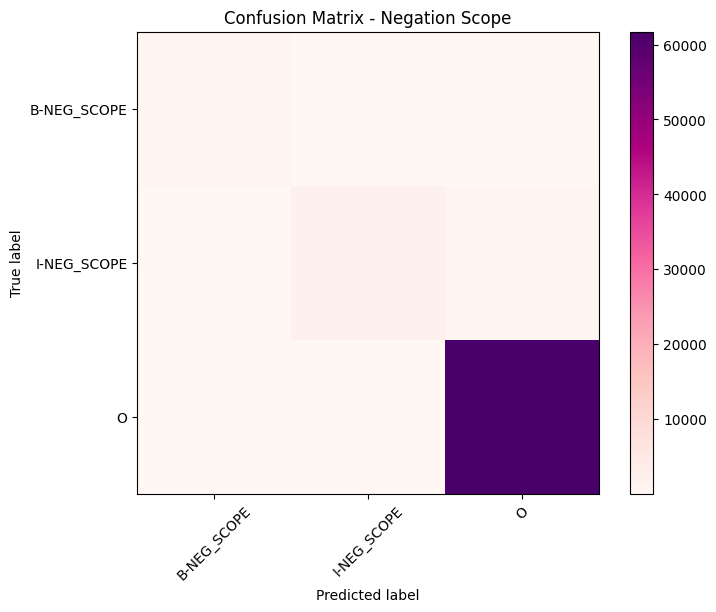

In [28]:
# Confusion matrix for negation (si no os gusta el titulo lo sacamos y dejamos solo el comentario este)
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Flatten the lists of lists bc in the confusion matrix we need list of labels, not list of slists.
y_test_flat_neg = [label for seq in y_test_NEG for label in seq]
y_pred_flat_neg = [label for seq in y_pred_NEG for label in seq]

# Get unique labels  --> Quereis que saquemos los out of scope???
labels_neg = sorted(set(y_test_flat_neg + y_pred_flat_neg))
# labels_neg = sorted({label for label in y_test_flat_neg + y_pred_flat_neg if label != 'O'})

# Confusion Matrix
cm_neg = confusion_matrix(y_test_flat_neg, y_pred_flat_neg, labels=labels_neg) # No se si quereis hacerlo así o hacerlo nosotras pero como que no lo tienen muy en cuen ta el codigo lo he puesto así.

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_neg, interpolation='nearest', cmap=plt.cm.RdPu)
plt.title("Confusion Matrix - Negation Scope")
plt.colorbar()
tick_marks = np.arange(len(labels_neg))
plt.xticks(tick_marks, labels_neg, rotation=45)
plt.yticks(tick_marks, labels_neg)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


### CRF for uncertainty scope detection

In [29]:
# CRF BIO tagging evaluation for UNCERTAINTY scopes
X_test_UNC, y_test_UNC, y_pred_UNC = train_and_evaluate_crf(df_crf_unc_train, df_crf_unc_test, "unc_scope_label")

CRF Evaluation for: UNC_SCOPE_LABEL
              precision    recall  f1-score   support

 B-UNC_SCOPE       0.91      0.24      0.38       129
 I-UNC_SCOPE       0.77      0.31      0.45       437
           O       0.99      1.00      1.00     64965

    accuracy                           0.99     65531
   macro avg       0.89      0.52      0.61     65531
weighted avg       0.99      0.99      0.99     65531



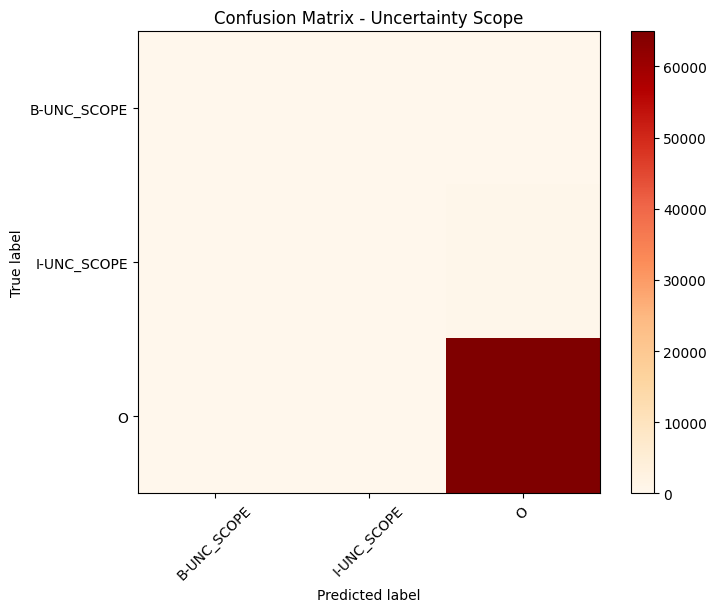

In [30]:
# Confusion matrix for uncertaninty

y_test_flat_unc = [label for seq in y_test_UNC for label in seq]
y_pred_flat_unc = [label for seq in y_pred_UNC for label in seq]

# Quereis sacar los 0?
labels_unc = sorted(set(y_test_flat_unc + y_pred_flat_unc))
#labels_unc = sorted({label for label in y_test_flat_unc + y_pred_flat_unc if label != 'O'})

cm_unc = confusion_matrix(y_test_flat_unc, y_pred_flat_unc, labels=labels_unc)

plt.figure(figsize=(8, 6))
plt.imshow(cm_unc, interpolation='nearest', cmap=plt.cm.OrRd)
plt.title("Confusion Matrix - Uncertainty Scope")
plt.colorbar()
tick_marks = np.arange(len(labels_unc))
plt.xticks(tick_marks, labels_unc, rotation=45)
plt.yticks(tick_marks, labels_unc)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [31]:
# TABLE WITH ALL COMBINED EXCLUDING THE OUTOFSCOPE: 
# Combine the BIO label sequences
y_test_all = y_test_NEG + y_test_UNC
y_pred_all = y_pred_NEG + y_pred_UNC

# Get all labels except 'O'
all_labels = set(label for seq in y_test_all for label in seq if label != 'O')
all_labels = sorted(all_labels)

# Print overall evaluation
print("Overall Evaluation (NEG + UNC scopes):")
print(metrics.flat_classification_report(
    y_test_all, y_pred_all, labels=all_labels, digits=3))

Overall Evaluation (NEG + UNC scopes):
              precision    recall  f1-score   support

 B-NEG_SCOPE      0.007     0.007     0.007      1071
 B-UNC_SCOPE      0.000     0.000     0.000       129
 I-NEG_SCOPE      0.015     0.013     0.014      2522
 I-UNC_SCOPE      0.000     0.000     0.000       437

   micro avg      0.012     0.010     0.011      4159
   macro avg      0.006     0.005     0.005      4159
weighted avg      0.011     0.010     0.010      4159



## Printing CRF Predictions vs. True labels
We display sample sentences with predicted and true BIO tags shown as `[true_tag|pred_tag]` next to each word, only if at least one tag isn't `'O'`. This highlights where the model correctly identifies scopes or makes mistakes, helping us quickly assess its performance on meaningful cases.

In [32]:
def print_crf_predictions(df, y_true, y_pred, sentence_idx=0):
    """
    Print the whole sentence in one line, adding true and predicted BIO tags in brackets next to tokens
    only if the tags are not 'O'.
    Format per token: word[true_tag|pred_tag] if either tag != 'O', else just word.
    """
    grouped = df.groupby("sentence_id")
    sentence_ids = list(grouped.groups.keys())

    if sentence_idx >= len(sentence_ids):
        print(f"Invalid sentence index {sentence_idx}. Max allowed: {len(sentence_ids) - 1}")
        return

    sentence_id = sentence_ids[sentence_idx]
    sentence_df = grouped.get_group(sentence_id).reset_index(drop=True)

    output_tokens = []
    for i, row in sentence_df.iterrows():
        word = row['word']
        true_label = y_true[sentence_idx][i]
        pred_label = y_pred[sentence_idx][i]

        # Show tags only if either true or pred label is not 'O'
        if true_label != 'O' or pred_label != 'O':
            display_word = f"{word} [{true_label}|{pred_label}]"
        else:
            display_word = word

        output_tokens.append(display_word)

    print(f"\n--- Sentence ID {sentence_id} ---")
    print(" ".join(output_tokens))

for i in range(5):
    print_crf_predictions(df_crf_neg_test, y_test_NEG, y_pred_NEG, sentence_idx=i)


--- Sentence ID 0 ---
 

--- Sentence ID 1 ---
nº historia clinica : * * * * * * * * nºepisodi : * * * * * * * * sexe : dona data de naixement : 12.05.1977 edat : 42 anys procedencia aguts servei obstetricia data d'ingres 27.09.2019 data d'alta 01.10.2019 13:00:00 ates per * * * * * * * * * * * * * * * * * , * * * * * * * * * * * * * * ; * * * * * * * * * * * * * * * * * , * * * * * informe d'alta d'hospitalitzacio motiu d'ingres induccion al parto por pequeño para la edad gestacional ( peg ) antecedents no alergias [B-NEG_SCOPE|B-NEG_SCOPE] medicamentosas [I-NEG_SCOPE|I-NEG_SCOPE] conocidas [O|I-NEG_SCOPE] antcededentes [O|I-NEG_SCOPE] medico-quirurgicos [O|I-NEG_SCOPE] : protesis mamaria , adenoidectomia niega habitos [B-NEG_SCOPE|B-NEG_SCOPE] toxicos [I-NEG_SCOPE|I-NEG_SCOPE] medicacio habitual anafranil25 mg/ diario .

--- Sentence ID 2 ---
yodocefol .

--- Sentence ID 3 ---
hierro oral .

--- Sentence ID 4 ---
ranitidina 150 mg .


In [33]:
shown = 0
max_to_show = 10

for i in range(len(y_test_NEG)):
    if any(tag != 'O' for tag in y_test_NEG[i]) or any(tag != 'O' for tag in y_pred_NEG[i]):
        print_crf_predictions(df_crf_neg_test, y_test_NEG, y_pred_NEG, sentence_idx=i)
        shown += 1
        if shown >= max_to_show:
            break


--- Sentence ID 1 ---
nº historia clinica : * * * * * * * * nºepisodi : * * * * * * * * sexe : dona data de naixement : 12.05.1977 edat : 42 anys procedencia aguts servei obstetricia data d'ingres 27.09.2019 data d'alta 01.10.2019 13:00:00 ates per * * * * * * * * * * * * * * * * * , * * * * * * * * * * * * * * ; * * * * * * * * * * * * * * * * * , * * * * * informe d'alta d'hospitalitzacio motiu d'ingres induccion al parto por pequeño para la edad gestacional ( peg ) antecedents no alergias [B-NEG_SCOPE|B-NEG_SCOPE] medicamentosas [I-NEG_SCOPE|I-NEG_SCOPE] conocidas [O|I-NEG_SCOPE] antcededentes [O|I-NEG_SCOPE] medico-quirurgicos [O|I-NEG_SCOPE] : protesis mamaria , adenoidectomia niega habitos [B-NEG_SCOPE|B-NEG_SCOPE] toxicos [I-NEG_SCOPE|I-NEG_SCOPE] medicacio habitual anafranil25 mg/ diario .

--- Sentence ID 10 ---
vih [B-NEG_SCOPE|B-NEG_SCOPE] negativo .

--- Sentence ID 11 ---
serologias : rubeola no inmune [B-NEG_SCOPE|B-NEG_SCOPE] , toxoplasma no immune [B-NEG_SCOPE|B-NEG_SC

In [34]:
shown = 0
max_to_show = 10

for i in range(len(y_test_UNC)):
    if any(tag != 'O' for tag in y_test_UNC[i]) or any(tag != 'O' for tag in y_pred_UNC[i]):
        print_crf_predictions(df_crf_neg_test, y_test_UNC, y_pred_UNC, sentence_idx=i)
        shown += 1
        if shown >= max_to_show:
            break


--- Sentence ID 138 ---
dado cuadro clinico y analitico que podria ser [B-UNC_SCOPE|O] compatible [I-UNC_SCOPE|O] con [I-UNC_SCOPE|O] sd [I-UNC_SCOPE|O] mononucleosido [I-UNC_SCOPE|O] se amplia estudio con determinacion de pcr de parvovirus b19 , toxoplasma y vhh-6 , con resultados pendientes .

--- Sentence ID 140 ---
orientacio diagnostica b34.9 infeccio virica no especificada neutropenia autolimitada fiebre de origen desconocido , posible viriasis [B-UNC_SCOPE|B-UNC_SCOPE] . [O|I-UNC_SCOPE]

--- Sentence ID 156 ---
antecedentes patologicos - elevacion de transaminasas posiblemente secundario [B-UNC_SCOPE|O] a [I-UNC_SCOPE|O] consumo [I-UNC_SCOPE|O] enolico [I-UNC_SCOPE|O] . [I-UNC_SCOPE|O]

--- Sentence ID 188 ---
hipoestesia simetrica en mmii hasta abdomen ( sin claro nivel [B-UNC_SCOPE|O] ) [I-UNC_SCOPE|O] .

--- Sentence ID 193 ---
atrofia hipotenar y posible atrofia [B-UNC_SCOPE|O] interoseos [I-UNC_SCOPE|O] ( paciente refiere que siempre ha permanecido asi ) .

--- Sentence ID